In [1]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
from torch.optim import lr_scheduler
import seaborn as sns
import matplotlib.pyplot as plt

Data Visualization 

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


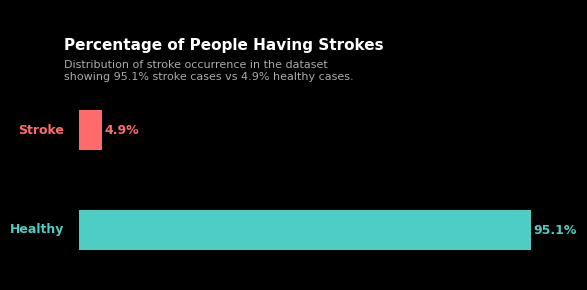

C:\Users\andre\AppData\Local\Temp\ipykernel_26452\1234943248.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(stroke_gen.index, **font_dict)
C:\Users\andre\AppData\Local\Temp\ipykernel_26452\1234943248.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Private','Self-Employed','Children', 'Gov-Job','Never worked'], **font_dict)
C:\Users\andre\AppData\Local\Temp\ipykernel_26452\1234943248.py:150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Yes','No'], **font_dict)
C:\Users\andre\AppData\Local\Temp\ipykernel_26452\1234943248.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set

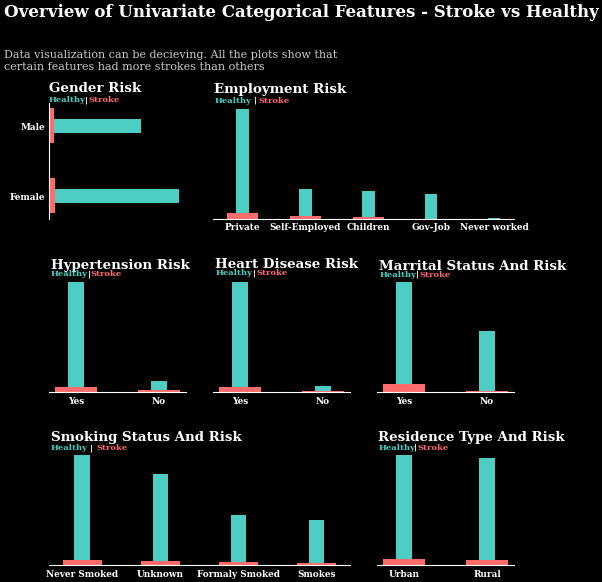

In [11]:
# Load and prepare the data
df = pd.read_csv(r"C:\Users\andre\Downloads\archive\healthcare-dataset-stroke-data.csv")
print(df.head(5))
def plot_stroke_distribution(df):
    # Calculate the counts and percentages
    x = pd.DataFrame(df.groupby(['stroke'])['stroke'].count())
    total = x.stroke.sum()
    percentages = (x.stroke / total * 100).round(1)
    
    # Set up the plot with narrower proportions
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    
    # Define colors for dark theme
    colors = {
        'Stroke': '#FF6B6B',  # Bright coral
        'Healthy': '#4ECDC4',  # Bright teal
        'background': 'black',  # Dark background
        'text': '#FFFFFF',  # White text
        'subtext': '#AAAAAA'  # Light gray for subtitle
    }
    
    # Create horizontal bars
    y_positions = [0, 1]
    bar_height = 0.4
    
    # Plot bars
    ax.barh(y_positions[0], percentages[0], height=bar_height, color=colors['Healthy'])
    ax.barh(y_positions[1], percentages[1], height=bar_height, color=colors['Stroke'])
    
    # Add percentage labels
    ax.text(percentages[0] + 0.5, y_positions[0], f'{percentages[0]}%', 
            va='center', ha='left', color=colors['Healthy'], fontsize=9, fontweight='bold')
    ax.text(percentages[1] + 0.5, y_positions[1], f'{percentages[1]}%', 
            va='center', ha='left', color=colors['Stroke'], fontsize=9, fontweight='bold')
    
    # Add category labels
    ax.text(-3, y_positions[0], 'Healthy', 
            va='center', ha='right', color=colors['Healthy'], fontsize=9, fontweight='bold')
    ax.text(-3, y_positions[1], 'Stroke', 
            va='center', ha='right', color=colors['Stroke'], fontsize=9, fontweight='bold')
    
    # Add title and subtitle
    ax.text(-3, 1.8, 'Percentage of People Having Strokes', 
            fontsize=11, fontweight='bold', color=colors['text'])
    ax.text(-3, 1.5, f'Distribution of stroke occurrence in the dataset\n'
            f'showing {percentages[0]}% stroke cases vs {percentages[1]}% healthy cases.',
            fontsize=8, color=colors['subtext'])
    
    # Clean up the plot
    ax.set_xlim(-5, 101)
    ax.set_ylim(-0.5, 2.2)
    
    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Remove all axes
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set background color
    fig.patch.set_facecolor(colors['background'])
    ax.set_facecolor(colors['background'])
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Usage example:
fig = plot_stroke_distribution(df)
plt.show()
fig = plt.figure(figsize = (15,15),dpi = 40)

gs = fig.add_gridspec(3,3)
gs.update(wspace = 0.2, hspace = 0.5)


ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1:])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0:2])
ax7 = fig.add_subplot(gs[2,2])

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

fig.patch.set_facecolor('black')

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('black')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('white')
    for loc in ['left', 'right', 'top']:
        ax.spines[loc].set_visible(False)
        ax.spines[loc].set_linewidth(2)


title_args = {'font':'Serif', 'weight':'bold','color': 'white', 'size':24}
font_dict = {'size':16, 'family':'Serif', 'color':'white', 'weight':'bold'}
health_dict = {'font':'Serif', 'color': '#4ECDC4', 'size':15, 'weight':'bold'}
dash_dict = {'font':'Serif', 'color': 'white', 'size':15,'weight':'bold'}
stroke_dict = {'font':'Serif', 'color': '#FF6B6B', 'size':15,'weight':'bold'}

stroke_col = '#FF6B6B'
healthy_col = '#4ECDC4'

# Ax1: Gender- stroke distributions
healthy_gen = df[df['stroke'] == 0].gender.value_counts()
stroke_gen = df[df['stroke'] == 1].gender.value_counts()

ax1.barh( stroke_gen.index , width = healthy_gen.values[0:2], height = 0.2, color = healthy_col)
ax1.barh( np.arange(len(stroke_gen.index)) , width = stroke_gen.values, height = 0.5, color = stroke_col)
ax1.set_yticklabels(stroke_gen.index, **font_dict)

ax1.axes.get_yaxis().set_visible(True)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['left'].set_color('white')
ax1.text(0,1.5, 'Gender Risk',**title_args)
ax1.text(0,1.35, 'Healthy',**health_dict)
ax1.text(790,1.35, '|',**dash_dict)
ax1.text(870,1.35, 'Stroke',**stroke_dict)

# Ax2: work type - stroke distributions
healthy_gen = df[df['stroke'] == 0].work_type.value_counts()
stroke_gen = df[df['stroke'] == 1].work_type.value_counts()

ax2.bar( healthy_gen.index , height = healthy_gen.values, width = 0.2, color = healthy_col)
ax2.bar( np.arange(len(stroke_gen.index)) , height = stroke_gen.values, width = 0.5, color= stroke_col)
ax2.set_xticklabels(['Private','Self-Employed','Children', 'Gov-Job','Never worked'], **font_dict)


ax2.text(-0.45,3200, 'Employment Risk',**title_args)
ax2.text(-0.45,2950, 'Healthy',**health_dict)
ax2.text(0.18,2950, '|',**dash_dict)
ax2.text(0.25,2950, 'Stroke',**stroke_dict)

# Ax3: hypertension - stroke distributions

healthy_gen = df[df['stroke'] == 0].hypertension.value_counts()
stroke_gen = df[df['stroke'] == 1].hypertension.value_counts()

ax3.bar(['Yes','No'] , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax3.bar( stroke_gen.index, height = stroke_gen.values, width = 0.5,color= stroke_col)
ax3.set_xticklabels(['Yes','No'], **font_dict)

ax3.text(-0.3,5000, 'Hypertension Risk',**title_args)
ax3.text(-0.3,4700, 'Healthy',**health_dict)
ax3.text(0.14,4700, '|',**dash_dict)
ax3.text(0.18,4700, 'Stroke',**stroke_dict)


# Ax4: Heart Disease - stroke distributions

healthy_gen = df[df['stroke'] == 0].heart_disease.value_counts()
stroke_gen = df[df['stroke'] == 1].heart_disease.value_counts()

ax4.bar(['Yes','No'] , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax4.bar( stroke_gen.index, height = stroke_gen.values, width = 0.5,color= stroke_col)
ax4.set_xticklabels(['Yes', 'No'],**font_dict)

ax4.text(-0.3,5250, 'Heart Disease Risk',**title_args)
ax4.text(-0.3,4950, 'Healthy',**health_dict)
ax4.text(0.15,4950, '|',**dash_dict)
ax4.text(0.20,4950, 'Stroke',**stroke_dict)


# Ax5: Married - stroke distributions
healthy_gen = df[df['stroke'] == 0].ever_married.value_counts()
stroke_gen = df[df['stroke'] == 1].ever_married.value_counts()

ax5.bar( healthy_gen.index , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax5.bar( np.arange(len(stroke_gen.index)) , height = stroke_gen.values, width = 0.5,color= stroke_col )
ax5.set_xticklabels(healthy_gen.index, **font_dict)

ax5.text(-0.3,3500, 'Marrital Status And Risk',**title_args)
ax5.text(-0.3,3300, 'Healthy',**health_dict)
ax5.text(0.14,3300, '|',**dash_dict)
ax5.text(0.18,3300, 'Stroke',**stroke_dict)




# Ax6: Smoking status - stroke distributions

healthy_gen = df[df['stroke'] == 0].smoking_status.value_counts()
stroke_gen = df[df['stroke'] == 1].smoking_status.value_counts()

ax6.bar( healthy_gen.index, height = healthy_gen.values, width = 0.2,color = healthy_col)
ax6.bar( np.arange(len(stroke_gen.index)) , height = stroke_gen.values, width = 0.5,color= stroke_col)
ax6.set_xticklabels(['Never Smoked', 'Unknown','Formaly Smoked' ,'Smokes'], **font_dict)

ax6.text(-0.4,2050, 'Smoking Status And Risk',**title_args)
ax6.text(-0.4,1900, 'Healthy',**health_dict)
ax6.text(0.095,1900, '|',**dash_dict)
ax6.text(0.18,1900, 'Stroke',**stroke_dict)




# Ax7: Residence type - stroke distributions

healthy_gen = df[df['stroke'] == 0].Residence_type.value_counts()
stroke_gen = df[df['stroke'] == 1].Residence_type.value_counts()

ax7.bar( healthy_gen.index , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax7.bar( np.arange(len(stroke_gen.index)) , height = stroke_gen.values, width = 0.5,color= stroke_col)
ax7.set_xticklabels(healthy_gen.index, **font_dict)

ax7.text(-0.31,2800, 'Residence Type And Risk',**title_args)
ax7.text(-0.31,2600, 'Healthy',**health_dict)
ax7.text(0.12,2600,'|',**dash_dict)
ax7.text(0.165,2600, 'Stroke',**stroke_dict)

fig.text(0.05,1.025, 'Overview of Univariate Categorical Features - Stroke vs Healthy', {'font':'Serif', 'color':'white','size':30, 'weight':'bold'})
fig.text(0.05,0.9375,'Data visualization can be decieving. All the plots show that\ncertain features had more strokes than others',{'font':'Serif', 'color':'white','size':20, 'weight':'normal'}, alpha = 0.8)

fig.show()

Data pre-processing

In [3]:

# Remove samples where gender is "Other"
df = df[df['gender'] != 'Other']

# Handle missing values
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# Convert categorical variables to numeric
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})  
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
work_type_dummies = pd.get_dummies(df['work_type'], drop_first=True)
df = pd.concat([df.drop('work_type', axis=1), work_type_dummies], axis=1)
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})
smoking_status_dummies = pd.get_dummies(df['smoking_status'], drop_first=True)
df = pd.concat([df.drop('smoking_status', axis=1), smoking_status_dummies], axis=1)

# Select features
features = ['age', 'gender', 'hypertension', 'heart_disease', 'ever_married',
           'Residence_type', 'avg_glucose_level', 'bmi',
           'Private', 'Self-employed', 'children', 'Never_worked',  # work_type features
           'formerly smoked', 'never smoked', 'smokes']  # smoking_status features
X = df[features]
y = df['stroke']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  w

Logistic Regression Model 

Accuracy: 0.7407

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.17      0.81      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.77      0.56      1022
weighted avg       0.93      0.74      0.81      1022



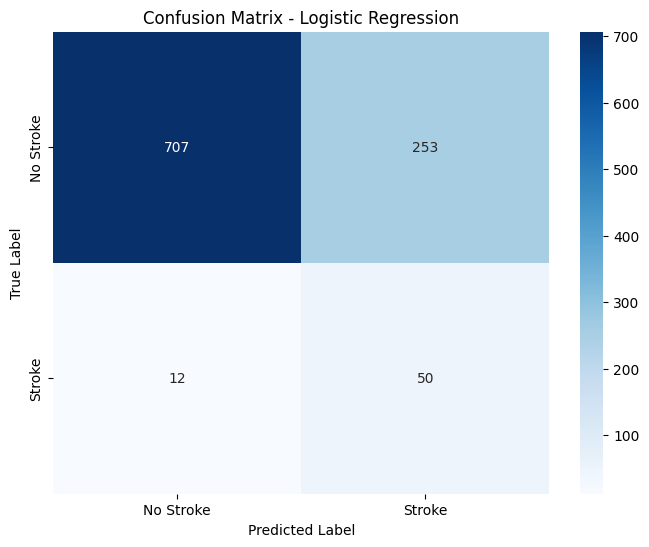


Feature Importance:
              Feature  Importance
0                 age    2.111724
10           children    0.597542
6   avg_glucose_level    0.217856
8             Private    0.146980
14             smokes    0.113803
2        hypertension    0.098446
1              gender    0.057844
3       heart_disease    0.037269
7                 bmi    0.010567
5      Residence_type    0.003038
4        ever_married   -0.022664
12    formerly smoked   -0.065747
9       Self-employed   -0.074592
11       Never_worked   -0.100015
13       never smoked   -0.130751


In [4]:
# logistic regression
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_binary = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Create and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))

SVM model

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  w


Final Model Performance on Test Set:
Accuracy: 0.8092

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       960
           1       0.16      0.48      0.24        62

    accuracy                           0.81      1022
   macro avg       0.56      0.66      0.56      1022
weighted avg       0.91      0.81      0.85      1022


Cross-validation Statistics:
Mean Accuracy: nan (±nan)
Mean Precision (Stroke): nan (±nan)
Mean Recall (Stroke): nan (±nan)

Generating confusion matrix and detailed metrics...


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value 

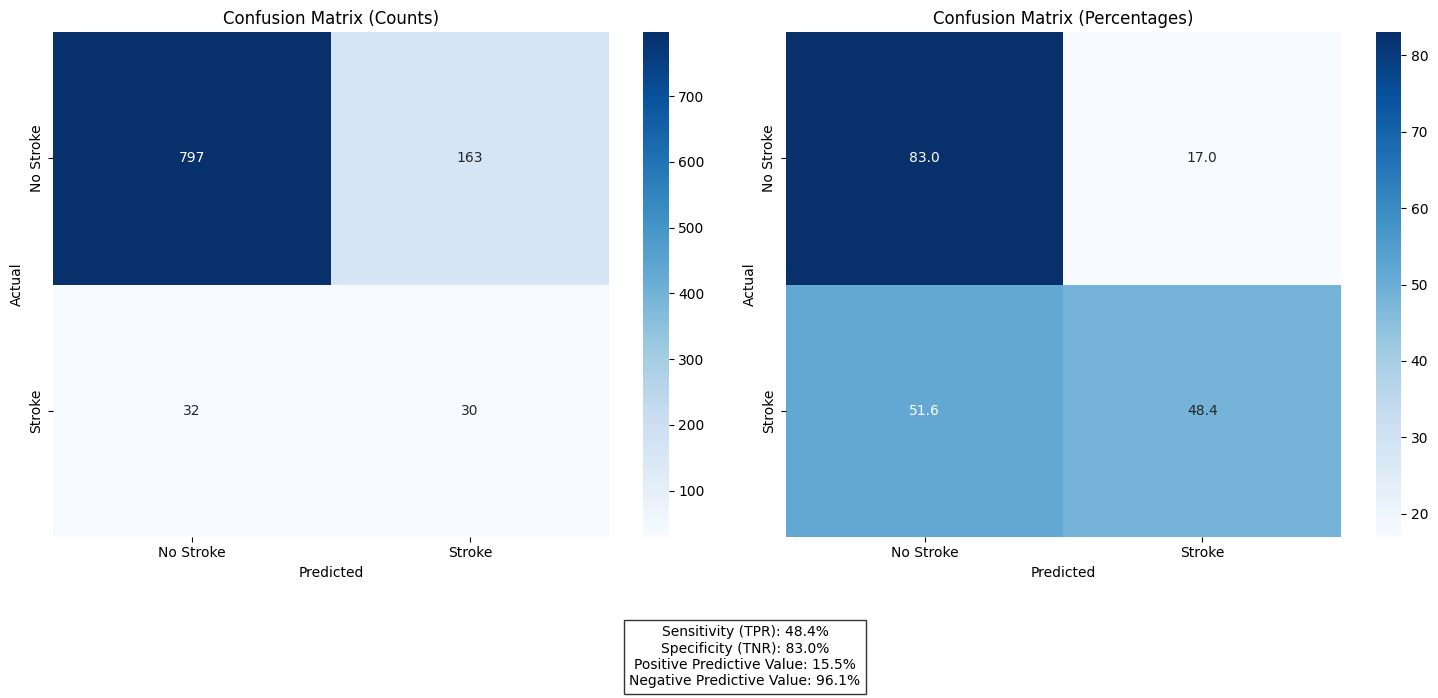


Detailed Performance Metrics:
True Negatives: 797
False Positives: 163
False Negatives: 32
True Positives: 30

Sensitivity (True Positive Rate): 48.4%
Specificity (True Negative Rate): 83.0%
Positive Predictive Value: 15.5%
Negative Predictive Value: 96.1%


In [5]:
# Initialize metrics storage
cv_scores = {
    'accuracy': [], 'precision_0': [], 'precision_1': [],
    'recall_0': [], 'recall_1': [], 'auc': []
}

# Setup StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize SVM
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=42,
    probability=True
)

# Train final model
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
svm_model.fit(X_train_smote, y_train_smote)

# Final predictions
y_pred = svm_model.predict(X_test_scaled)

# Print results
print("\nFinal Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nCross-validation Statistics:")
print(f"Mean Accuracy: {np.mean(cv_scores['accuracy']):.4f} (±{np.std(cv_scores['accuracy']):.4f})")
print(f"Mean Precision (Stroke): {np.mean(cv_scores['precision_1']):.4f} (±{np.std(cv_scores['precision_1']):.4f})")
print(f"Mean Recall (Stroke): {np.mean(cv_scores['recall_1']):.4f} (±{np.std(cv_scores['recall_1']):.4f})")
def plot_svm_results(y_true, y_pred, y_prob=None):
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix with absolute numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # Add labels to the plot
    class_labels = ['No Stroke', 'Stroke']
    ax1.set_xticklabels(class_labels)
    ax1.set_yticklabels(class_labels)
    
    # Plot confusion matrix with percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_xticklabels(class_labels)
    ax2.set_yticklabels(class_labels)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    ppv = tp / (tp + fp) * 100
    npv = tn / (tn + fn) * 100
    
    # Add metrics text
    metrics_text = (
        f'Sensitivity (TPR): {sensitivity:.1f}%\n'
        f'Specificity (TNR): {specificity:.1f}%\n'
        f'Positive Predictive Value: {ppv:.1f}%\n'
        f'Negative Predictive Value: {npv:.1f}%'
    )
    
    plt.figtext(0.5, -0.15, metrics_text, ha='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Performance Metrics:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"\nSensitivity (True Positive Rate): {sensitivity:.1f}%")
    print(f"Specificity (True Negative Rate): {specificity:.1f}%")
    print(f"Positive Predictive Value: {ppv:.1f}%")
    print(f"Negative Predictive Value: {npv:.1f}%")
    
    return {
        'confusion_matrix': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv
    }

# Add these lines after your existing SVM code
print("\nGenerating confusion matrix and detailed metrics...")
# Get probability scores for ROC curve
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
# Plot confusion matrix and get metrics
metrics = plot_svm_results(y_test, y_pred, y_prob)

In [6]:
# Convert numpy arrays to PyTorch tensors
X_train_balanced = torch.FloatTensor(X_train_balanced)
y_train_balanced = torch.FloatTensor(y_train_balanced)
X_test_scaled = torch.FloatTensor(X_test_scaled)
y_test = torch.FloatTensor(y_test.values)

neural network designed by connecting three resnet blocks

In [7]:
# three resnet block neural network
# Create PyTorch Dataset
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 1. Add ResNet block class
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

# 2. Modified model with ResNet blocks
class StrokePredictor(nn.Module):
    def __init__(self, input_dim):
        super(StrokePredictor, self).__init__()
        
        # Initial layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        # ResNet blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(512),
            ResidualBlock(512),
            ResidualBlock(512)
        )
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        x = self.output_layers(x)
        return x
# Create data loaders
train_dataset = StrokeDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Add this before model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights more precisely
class_weights = torch.FloatTensor([1.0, 12.0]).to(device)
criterion = nn.BCELoss(weight=class_weights[1])

# Initialize model with improved optimizer settings
model = StrokePredictor(len(features)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.005)

# Define num_epochs first
num_epochs = 100

# Move scheduler initialization after num_epochs definition
scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                  max_lr=0.001,
                                  epochs=num_epochs,
                                  steps_per_epoch=len(train_loader),
                                  pct_start=0.2)

# Add validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32)

# Training loop with early stopping
best_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

# Modify training loop with gradient accumulation
accumulation_steps = 4

In [8]:
# 3. Modified training loop with detailed monitoring
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            
            preds = (outputs.squeeze() > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    
    return avg_loss, f1, accuracy

# Modified training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_train_loss, train_f1, train_acc = evaluate_model(model, train_loader, criterion, device)
        avg_val_loss, val_f1, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        print(f"Training   - Loss: {avg_train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
    
    # Early stopping check
    avg_val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

# Modified evaluation
def evaluate_with_threshold_tuning(model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.1)):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
    
    # Convert y_test to numpy array first
    y_test_numpy = y_test.cpu().numpy()
    
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (predictions > threshold).astype(int)
        f1 = f1_score(y_test_numpy, y_pred)  # Now both are numpy arrays
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

# Find best threshold and evaluate
best_threshold = evaluate_with_threshold_tuning(model, X_test_scaled, y_test)

# Final evaluation with best threshold
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_scaled.to(device)).cpu().numpy()
    y_pred = (test_predictions > best_threshold).astype(int)


Epoch [10/100]
--------------------------------------------------
Training   - Loss: 3.2590, F1: 0.8958, Acc: 0.8847
Validation - Loss: 3.4602, F1: 0.8915, Acc: 0.8776

Epoch [20/100]
--------------------------------------------------
Training   - Loss: 2.5262, F1: 0.9162, Acc: 0.9091
Validation - Loss: 2.5970, F1: 0.9183, Acc: 0.9103

Epoch [30/100]
--------------------------------------------------
Training   - Loss: 2.0164, F1: 0.9316, Acc: 0.9273
Validation - Loss: 2.1132, F1: 0.9329, Acc: 0.9276

Epoch [40/100]
--------------------------------------------------
Training   - Loss: 1.5530, F1: 0.9508, Acc: 0.9486
Validation - Loss: 1.6283, F1: 0.9502, Acc: 0.9468

Epoch [50/100]
--------------------------------------------------
Training   - Loss: 1.5911, F1: 0.9473, Acc: 0.9446
Validation - Loss: 1.6718, F1: 0.9461, Acc: 0.9423

Epoch [60/100]
--------------------------------------------------
Training   - Loss: 1.3731, F1: 0.9580, Acc: 0.9563
Validation - Loss: 1.3834, F1: 0.9576


Model Evaluation Results:
--------------------------------------------------
Best Classification Threshold: 0.500

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       960
         1.0       0.14      0.24      0.18        62

    accuracy                           0.86      1022
   macro avg       0.55      0.57      0.55      1022
weighted avg       0.90      0.86      0.88      1022


Confusion Matrix:


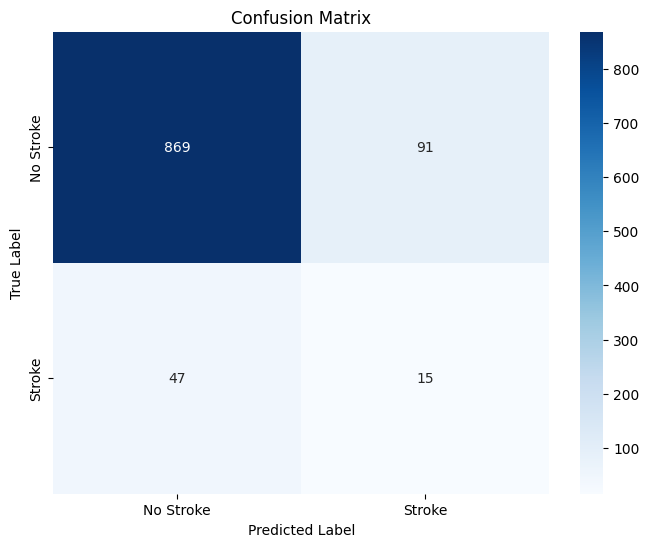


Detailed Metrics:
Accuracy Score: 0.865
F1 Score: 0.179


In [9]:
# Print evaluation metrics
print("\nModel Evaluation Results:")
print("-" * 50)
print(f"Best Classification Threshold: {best_threshold:.3f}")

# Convert y_test to numpy array once for all metrics
y_test_numpy = y_test.cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_test_numpy, y_pred))
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_numpy, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print("\nDetailed Metrics:")
print(f"Accuracy Score: {accuracy_score(y_test_numpy, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test_numpy, y_pred):.3f}")

# FocalLoss class remains the same
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)

# Use focal loss instead of BCE
criterion = FocalLoss(alpha=2, gamma=3)

Fully connected Nerual Network Model

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti

Epoch [10/100]
--------------------------------------------------
Training   - Loss: 5.2451, F1: 0.8237, Acc: 0.8081
Validation - Loss: 5.1942, F1: 0.8284, Acc: 0.8109

Epoch [20/100]
--------------------------------------------------
Training   - Loss: 4.5672, F1: 0.8416, Acc: 0.8278
Validation - Loss: 4.5100, F1: 0.8466, Acc: 0.8314

Epoch [30/100]
--------------------------------------------------
Training   - Loss: 3.7450, F1: 0.8763, Acc: 0.8659
Validation - Loss: 3.7157, F1: 0.8830, Acc: 0.8718

Epoch [40/100]
--------------------------------------------------
Training   - Loss: 3.0272, F1: 0.9045, Acc: 0.8964
Validation - Loss: 2.9841, F1: 0.9088, Acc: 0.9000

Epoch [50/100]
--------------------------------------------------
Training   - Loss: 2.4038, F1: 0.9299, Acc: 0.9254
Validation - Loss: 2.3695, F1: 0.9330, Acc: 0.9276

Epoch [60/100]
--------------------------------------------------
Training   - Loss: 2.1090, F1: 0.9334

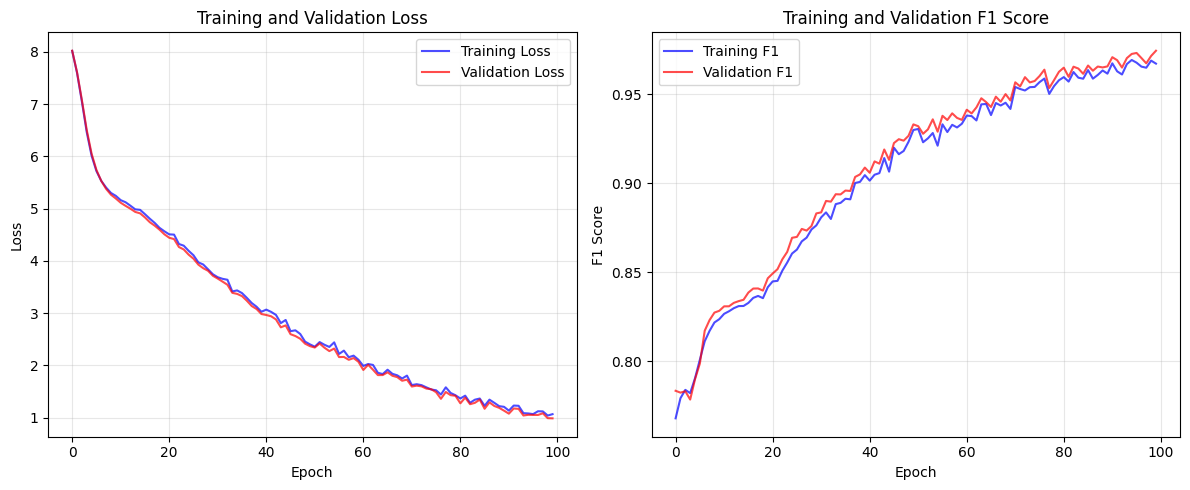


Training visualization has been saved as 'training_metrics.png'


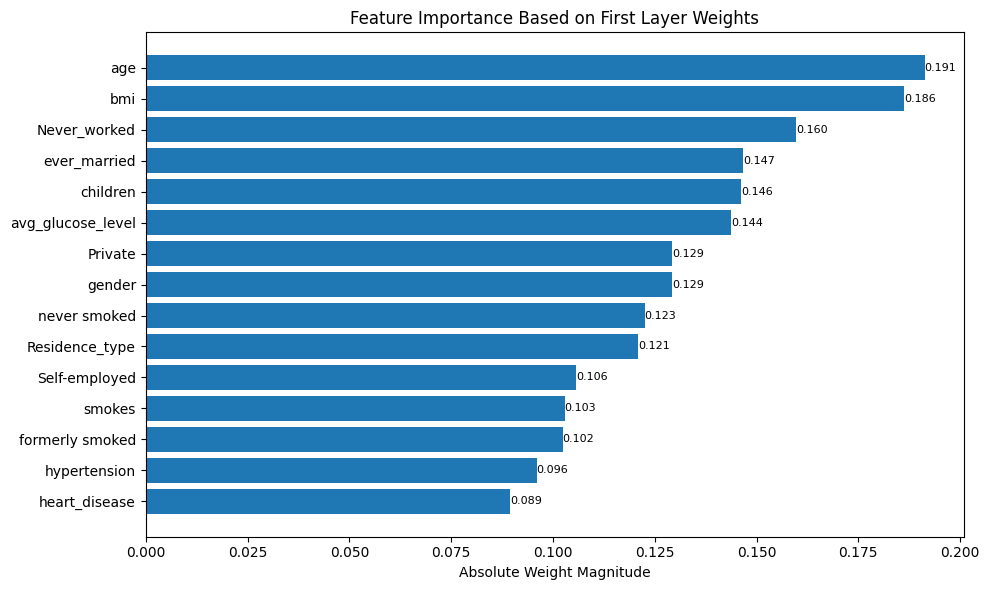


Feature importance visualization has been saved as 'feature_importance.png'

Model Evaluation Results:
--------------------------------------------------
Best Classification Threshold: 0.100

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       960
         1.0       0.12      0.34      0.18        62

    accuracy                           0.81      1022
   macro avg       0.54      0.59      0.54      1022
weighted avg       0.90      0.81      0.85      1022


Model Evaluation Results:
--------------------------------------------------
Best Classification Threshold: 0.100

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       960
         1.0       0.12      0.34      0.18        62

    accuracy                           0.81      1022
   macro avg       0.54      0.59      0.54      1022
weighted avg       0.90      0.81      0.85   

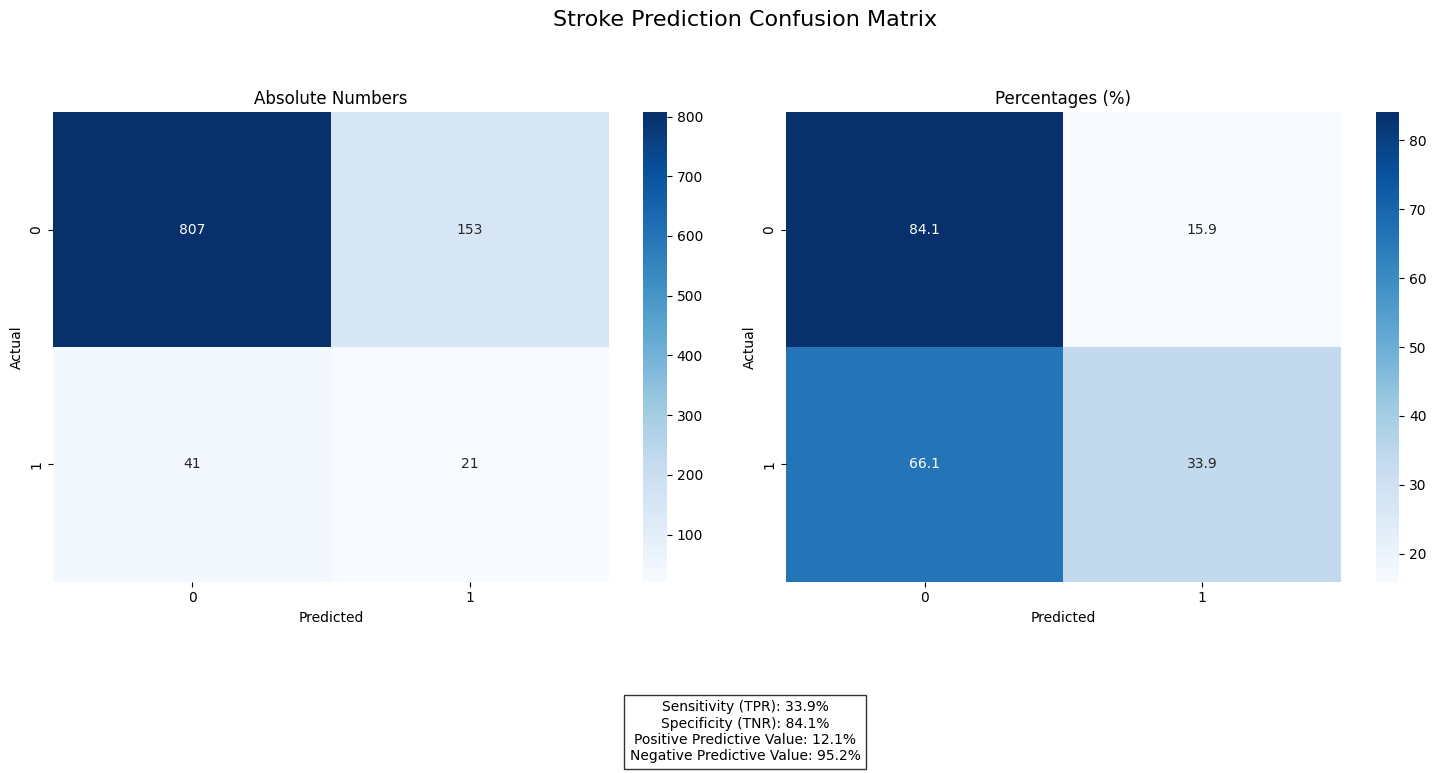


Detailed Metrics from Confusion Matrix:
Sensitivity (True Positive Rate): 33.9%
Specificity (True Negative Rate): 84.1%
Positive Predictive Value: 12.1%
Negative Predictive Value: 95.2%


In [10]:
# Create PyTorch Dataset
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class FCNN(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_sizes=[512, 256, 128], num_classes=1):
        super(FCNN, self).__init__()
        
        # Create layers list to hold all linear layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        layers.append(nn.Sigmoid())
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        return self.model(x)


def get_fcnn():
    """
    Returns an instance of the FCNN model.
    """
    return FCNN()


# Create data loaders
train_dataset = StrokeDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Add this before model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add this after device initialization
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Calculate class weights more precisely
class_weights = torch.FloatTensor([1.0, 12.0]).to(device)
criterion = nn.BCELoss(weight=class_weights[1])

# Initialize model with improved optimizer settings
model = FCNN(len(features)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.005)

# Define num_epochs first
num_epochs = 100

# Move scheduler initialization after num_epochs definition
scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                  max_lr=0.001,
                                  epochs=num_epochs,
                                  steps_per_epoch=len(train_loader),
                                  pct_start=0.2)

# Add validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32)

# Training loop with early stopping
best_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

# Modify training loop with gradient accumulation
accumulation_steps = 4

# 3. Modified training loop with detailed monitoring
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            
            preds = (outputs.squeeze() > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    
    return avg_loss, f1, accuracy

# Add lists to store metrics
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

# Modified training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Calculate and store metrics every epoch
    avg_train_loss, train_f1, train_acc = evaluate_model(model, train_loader, criterion, device)
    avg_val_loss, val_f1, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        print(f"Training   - Loss: {avg_train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
    
    # Early stopping check
    avg_val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

# Add visualization after training
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Training F1', color='blue', alpha=0.7)
plt.plot(val_f1s, label='Validation F1', color='red', alpha=0.7)
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()  # This will display the plot in addition to saving it

print("\nTraining visualization has been saved as 'training_metrics.png'")

# Add feature importance visualization
def plot_feature_importance(model, feature_names):
    # Get the weights from the first layer
    first_layer_weights = abs(model.model[0].weight.data.cpu().numpy())
    
    # Calculate importance scores (mean absolute weight for each feature)
    importance_scores = np.mean(first_layer_weights, axis=0)
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(feature_importance)), feature_importance['Importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Absolute Weight Magnitude')
    plt.title('Feature Importance Based on First Layer Weights')
    
    # Add value labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function after training
plot_feature_importance(model, features)
print("\nFeature importance visualization has been saved as 'feature_importance.png'")

# Modified evaluation
def evaluate_with_threshold_tuning(model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.1)):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (predictions > threshold).astype(int)
        f1 = f1_score(y_test_np, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

# Find best threshold and evaluate
best_threshold = evaluate_with_threshold_tuning(model, X_test_scaled, y_test)

# Final evaluation with best threshold
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_scaled.to(device)).cpu().numpy()
    y_pred = (test_predictions > best_threshold).astype(int)

# Print evaluation metrics
print("\nModel Evaluation Results:")
print("-" * 50)
print(f"Best Classification Threshold: {best_threshold:.3f}")
print("\nClassification Report:")
print(classification_report(y_test.cpu(), y_pred))

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_scaled.to(device)).cpu().numpy()
    y_pred = (test_predictions > best_threshold).astype(int)
    y_test_np = y_test.cpu().numpy()  # Convert to numpy array once

# Print evaluation metrics
print("\nModel Evaluation Results:")
print("-" * 50)
print(f"Best Classification Threshold: {best_threshold:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred))

print("\nDetailed Metrics:")
print(f"Accuracy Score: {accuracy_score(y_test_np, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test_np, y_pred):.3f}")

# Rest of the code remains the same
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)

# Use focal loss instead of BCE
criterion = FocalLoss(alpha=2, gamma=3)

# Ensure data is on GPU
X_train_balanced = X_train_balanced.to(device)
y_train_balanced = y_train_balanced.to(device)
X_test_scaled = X_test_scaled.to(device)
y_test = y_test.to(device)

def print_model_size(model):
    param_size = 0
    buffer_size = 0
    
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    print(f'\nModel Size:')
    print(f'Number of parameters: {sum(p.numel() for p in model.parameters()):,}')
    print(f'Memory footprint: {size_all_mb:.3f} MB')

# Call this after model creation
print_model_size(model)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot absolute numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Absolute Numbers')
    
    # Plot percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title('Percentages (%)')
    
    # Add overall title
    fig.suptitle(title, fontsize=16, y=1.05)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100  # True Positive Rate
    specificity = tn / (tn + fp) * 100  # True Negative Rate
    ppv = tp / (tp + fp) * 100  # Positive Predictive Value
    npv = tn / (tn + fn) * 100  # Negative Predictive Value
    
    # Add metrics text below the plots
    metrics_text = (
        f'Sensitivity (TPR): {sensitivity:.1f}%\n'
        f'Specificity (TNR): {specificity:.1f}%\n'
        f'Positive Predictive Value: {ppv:.1f}%\n'
        f'Negative Predictive Value: {npv:.1f}%'
    )
    
    plt.figtext(0.5, -0.2, metrics_text, ha='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv
    }

# Generate the confusion matrix visualization
# Make sure y_test is on CPU and converted to numpy
y_test_np = y_test.cpu().numpy()
metrics = plot_confusion_matrix(y_test_np, y_pred, title='Stroke Prediction Confusion Matrix')

# Print detailed metrics
print("\nDetailed Metrics from Confusion Matrix:")
print(f"Sensitivity (True Positive Rate): {metrics['sensitivity']:.1f}%")
print(f"Specificity (True Negative Rate): {metrics['specificity']:.1f}%")
print(f"Positive Predictive Value: {metrics['ppv']:.1f}%")
print(f"Negative Predictive Value: {metrics['npv']:.1f}%")